In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [7]:
!gdown --id 1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl

Downloading...
From: https://drive.google.com/uc?id=1_q37TRIFwtwhmSeLu_4h3SkFHrDSjeyl
To: /content/pfcn_small.npz
100% 137M/137M [00:03<00:00, 41.3MB/s]


In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [13]:
pfcn_small = np.load('/content/pfcn_small.npz')

In [15]:
train_big_images = pfcn_small['train_images']
test_big_images = pfcn_small['test_images']

In [17]:
train_big_images.shape, test_big_images.shape

((1700, 100, 75, 3), (300, 100, 75, 3))

In [26]:
train_small_images = resize(train_big_images,(1700,50,37,3))
test_small_images = resize(test_big_images,(300,50,37,3))

In [27]:
from skimage.transform import resize

In [28]:
train_small_images.shape

(1700, 50, 37, 3)

In [30]:
test_small_images.shape

(300, 50, 37, 3)

In [34]:
print(train_big_images[train_big_images!= 0][:10])
print(train_small_images[train_small_images!= 0][:10])

[0.23627451 0.34803922 0.64705882 0.24509804 0.35686275 0.65588235
 0.25490196 0.36470588 0.66470588 0.2372549 ]
[0.24306544 0.35541527 0.65414226 0.24706882 0.35551775 0.65607215
 0.2457701  0.35606925 0.65572801 0.24647147]


In [35]:
print(train_big_images.min(), train_big_images.max())
print(test_big_images.min(), test_big_images.max())

0.0 1.0
0.0 1.0


In [36]:
five = train_big_images[:5]
five.shape

(5, 100, 75, 3)

In [37]:
five.transpose((1,0,2,3)).reshape((100,-1,3)).shape

(100, 375, 3)

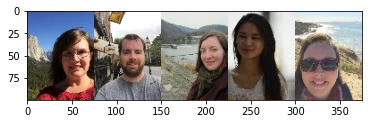

In [38]:
plt.imshow(five.transpose((1,0,2,3)).reshape((100,-1,3)))
plt.show()

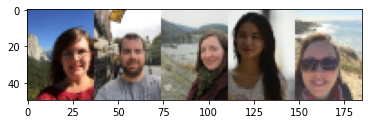

In [40]:
five_small = train_small_images[:5]
plt.imshow(five_small.transpose((1,0,2,3)).reshape((50,-1,3)))
plt.show()

In [41]:
# input (50, 37, 3), output (100, 75, 3)을 처리할 수 있는 모래시계 모양의 모델을 작성하세요.
from keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from keras.models import Model
from keras.layers import MaxPool2D, BatchNormalization, Activation, Dropout, concatenate

In [42]:
def conv2d_block(x, channel):
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(channel, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [43]:
def unet_sr():
    inputs = Input((50,37,3))
    
    c1 = conv2d_block(inputs, 16)
    p1 = MaxPool2D(2)(c1)
    d1 = Dropout(0.1)(p1)
    
    c2 = conv2d_block(d1, 32)
    p2 = MaxPool2D(2)(c2)
    d2 = Dropout(0.1)(p2)
    
    c3 = conv2d_block(d2, 64)
    p3 = MaxPool2D(2)(c3)
    d3 = Dropout(0.1)(p3)
    
    c4 = conv2d_block(d3, 128)
    p4 = MaxPool2D(2)(c4)
    d4 = Dropout(0.1)(p4)
    
    c5 = conv2d_block(d4, 256)
    
    u6 = Conv2DTranspose(128, 2, 2)(c5)
    u6 = concatenate([u6,c4])
    u6 = Dropout(0.1)(u6)
    c6 = conv2d_block(u6, 128)
    
    u7 = Conv2DTranspose(64, 2, 2, padding='valid', output_padding=(0,1))(c6)
    u7 = concatenate([u7,c3])
    u7 = Dropout(0.1)(u7)
    c7 = conv2d_block(u7, 64)
    
    u8 = Conv2DTranspose(32, 2, 2, padding='valid', output_padding=(1,0))(c7)
    u8 = concatenate([u8,c2])
    u8 = Dropout(0.1)(u8)
    c8 = conv2d_block(u8, 32)
    
    u9 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=(0,1))(c8)
    u9 = concatenate([u9,c1])
    u9 = Dropout(0.1)(u9)
    c9 = conv2d_block(u9, 16)
    
    u10 = Conv2DTranspose(16, 2, 2, padding='valid', output_padding=(0,1))(c9)
    outputs = Conv2D(3,1, activation='sigmoid')(u10)
    model = Model(inputs, outputs)
    return model

In [44]:
model = unet_sr()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50, 37, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 50, 37, 16)   448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 50, 37, 16)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 50, 37, 16)   0           ['batch_normalization[0][0]']

In [46]:
# 만든 모델에 loss는 mae, optimizer는 adam 매트릭은 accuracy으로 설정하는 코드를 작성하세요.
model.compile(loss='mae', optimizer='adam', metrics=['acc'])

In [47]:
hist = model.fit(
    train_small_images,
    train_big_images,
    validation_data=(test_small_images, test_big_images),
    epochs = 25,
    verbose = 1
)

Epoch 1/25
54/54 [==============================] - 49s 823ms/step - loss: 0.1645 - acc: 0.4623 - val_loss: 0.2180 - val_acc: 0.6880
Epoch 2/25
54/54 [==============================] - 45s 833ms/step - loss: 0.0880 - acc: 0.6260 - val_loss: 0.1874 - val_acc: 0.6892
Epoch 3/25
54/54 [==============================] - 45s 836ms/step - loss: 0.0712 - acc: 0.7204 - val_loss: 0.1711 - val_acc: 0.7131
Epoch 4/25
54/54 [==============================] - 44s 813ms/step - loss: 0.0632 - acc: 0.7708 - val_loss: 0.1333 - val_acc: 0.7725
Epoch 5/25
54/54 [==============================] - 44s 821ms/step - loss: 0.0603 - acc: 0.7863 - val_loss: 0.1091 - val_acc: 0.7884
Epoch 6/25
54/54 [==============================] - 44s 816ms/step - loss: 0.0588 - acc: 0.7828 - val_loss: 0.0845 - val_acc: 0.8071
Epoch 7/25
54/54 [==============================] - 44s 817ms/step - loss: 0.0573 - acc: 0.7876 - val_loss: 0.0710 - val_acc: 0.7944
Epoch 8/25
54/54 [==============================] - 44s 812ms/step - 

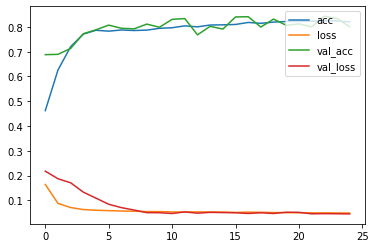

In [48]:
# hist의 accuracy plt의 plot을 이용하여 출력하는 코드를 작성하세요.
plt.plot(hist.history['acc'], label='acc')
plt.plot(hist.history['loss'], label='loss')
plt.plot(hist.history['val_acc'], label='val_acc')
plt.plot(hist.history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.show()

In [49]:
# 모델에 test_small_images 중 1장을 넣고 결과를 받는 코드를 작성하세요.
res = model.predict(test_small_images[1:2])

In [50]:
# test_small_images[1]을 resize 함수를 이용해여 (100, 75, 3) 으로 2배 확대하는 코드를 작성하세요.
exp = resize(test_small_images[1], (100,75,3))
exp.shape

(100, 75, 3)

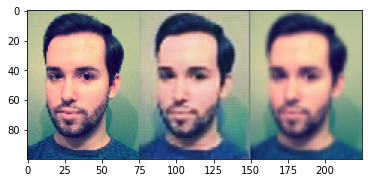

In [51]:
# res와 확대한 이미지, test_big_images[1]]를 width 방향으로 결합하여 (100, 75 * 3, 1) 의 이미지를 만들어 plt로 출력하는 코드를 작성하세요.
plt.imshow(np.concatenate([test_big_images[1], res[0], exp], axis=1))
plt.show()

In [52]:
# 3장의 이미지를 모델에 넣고 결과를 23번 같은 방식으로 비교하는 코드를 작성하세요
three = model.predict(test_small_images[:3])

In [53]:
exps = resize(test_small_images[:3], (3,100,75,3))
exps.shape

(3, 100, 75, 3)

In [54]:
x = np.concatenate([test_big_images[:3], three, exps], axis=2).reshape((300, -1, 3))